In [44]:
import pandas as pd
import os
import numpy as np
import librosa.display
import IPython
import matplotlib.pyplot as plt
import librosa
from scipy.io.wavfile import read as read_wav
import seaborn as sns
import torchaudio
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
import torch
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

In [155]:
def load_data_to_df(data_dir='shords_dataset/'):
    data = []
    for cl in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, cl)
        for file in os.listdir(class_dir):
            if file.endswith('.wav'):
                file_path = os.path.join(class_dir, file)
                
                # waveforms , _ = torchaudio.load(file_path)
                # waveforms = waveforms[:,:].mean(axis = 0)
                # specgram = torchaudio.transforms.Spectrogram(waveforms)
                # sp_shape = specgram.shape

                # Load audio file
                y, sr = librosa.load(file_path, sr=None)
                
                # Compute mel-spectrogram
                mel_spec = librosa.feature.melspectrogram(y=y, sr=16000 , n_mels = 320)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                
                # Store data
                data.append({'file_path': file_path, 'class': cl, 'mel_spectrogram': mel_spec_db, 'sr': sr, 'y': y})
    
    df = pd.DataFrame(data)
    return df

In [156]:
def print_random_mel_spectrograms(df, num_samples=10):
    random_indices = random.sample(range(len(df)), num_samples)
    
    for idx in random_indices:
        mel_spec = df['mel_spectrogram'][idx]
        cl = df['class'][idx]
        file_path = df['file_path'][idx]
        sr = df['sr'][idx]
        y = df['y'][idx]
        
        # Plot mel-spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-Spectrogram ({cl})')
        plt.tight_layout()
        plt.show()
        
     
        ipd.display(ipd.Audio(data=y, rate=sr))
        
        # Print file path
        print(f"File Path: {file_path}")
        print("=" * 50)


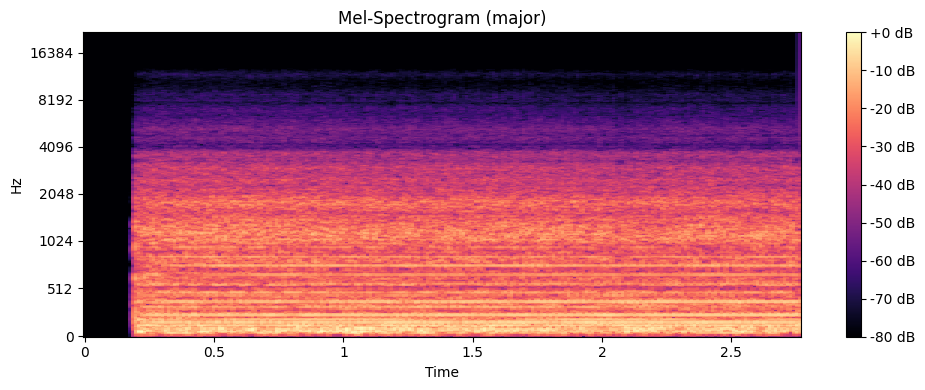

File Path: shords_dataset/major/9_13.wav


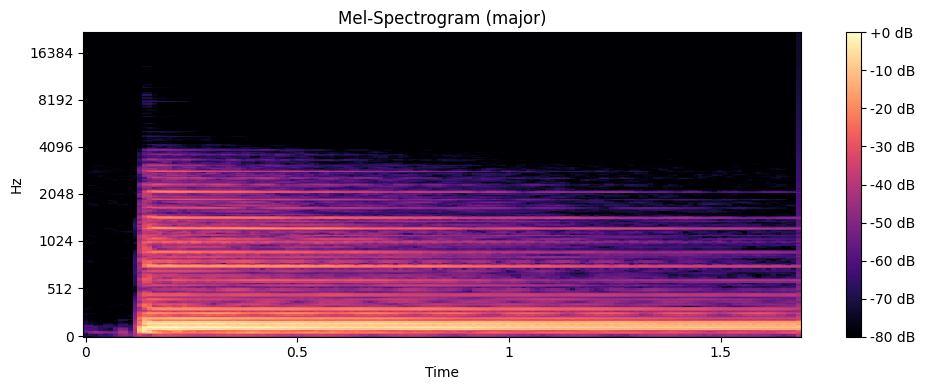

File Path: shords_dataset/major/9_26.wav


In [157]:
# Load data
data_dir = 'shords_dataset/'
df = load_data_to_df(data_dir)

# Print 10 random mel-spectrograms
print_random_mel_spectrograms(df, num_samples=2)


In [158]:
import torch
import torch.nn.functional as F
import librosa
def resize_mel_spectrograms(df, target_shape=(128, 256)):
    # Initialize an empty list to store resized mel-spectrograms
    resized_specs = []
    
    # Resize all mel-spectrograms to match maximum dimensions
    resized_specs = []
    for spec in df['mel_spectrogram']:
        spec_tensor = torch.tensor(spec).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        
        # Resize using PyTorch interpolate function
        resized_tensor = F.interpolate(spec_tensor, size=target_shape, mode='bilinear', align_corners=False)
        
        # Convert back to numpy array
        resized_spec = resized_tensor.squeeze().numpy()
        
        # Append resized mel-spectrogram to the list
        resized_specs.append(resized_spec)
    
    # Create a new DataFrame with resized mel-spectrograms
    df_resized = pd.DataFrame({
        'file_path': df['file_path'],
        'class': df['class'],
        'mel_spectrogram': resized_specs,
        'sr': df['sr'], 
        'y': df['y']
    })
    
    return df_resized

# Example usage:
df_resized = resize_mel_spectrograms(df)

In [159]:
df_resized['mel_spectrogram'][5].shape

(128, 256)

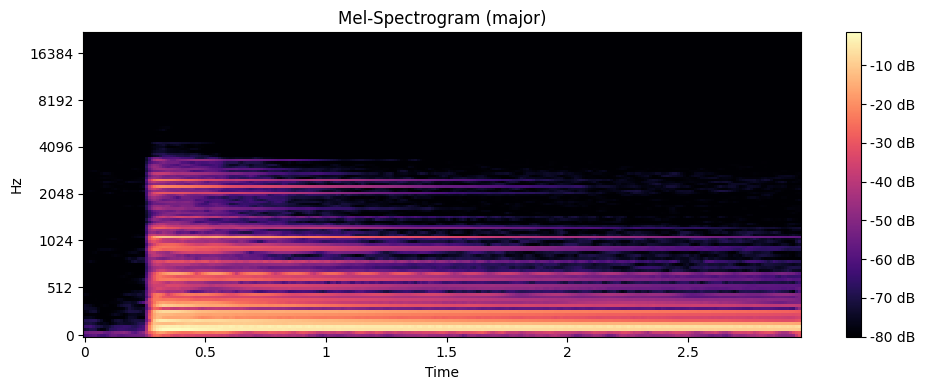

File Path: shords_dataset/major/5_18.wav


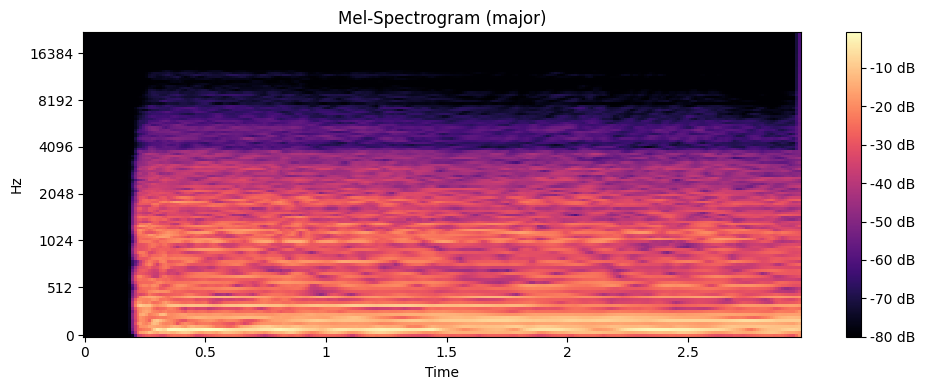

File Path: shords_dataset/major/9_62.wav


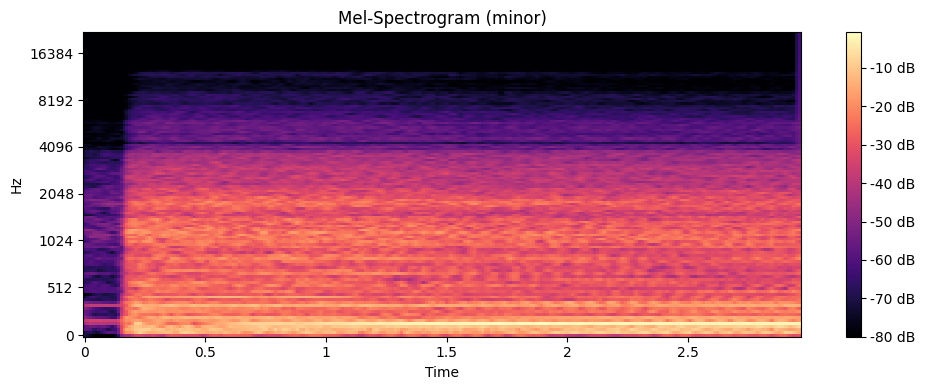

File Path: shords_dataset/minor/7_51.wav


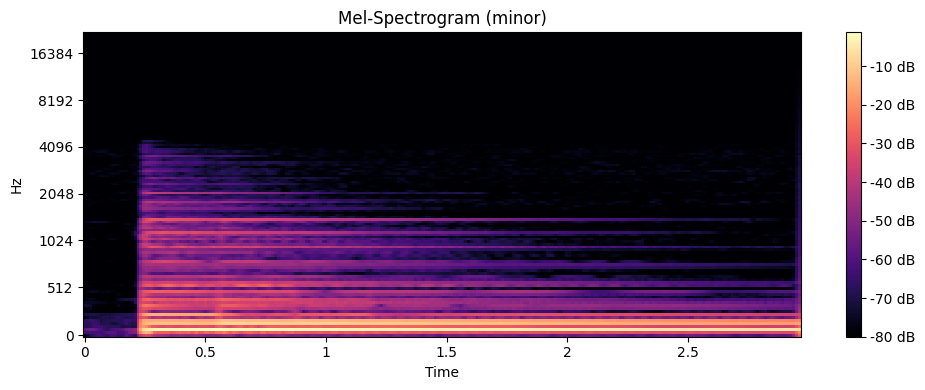

File Path: shords_dataset/minor/2_19.wav


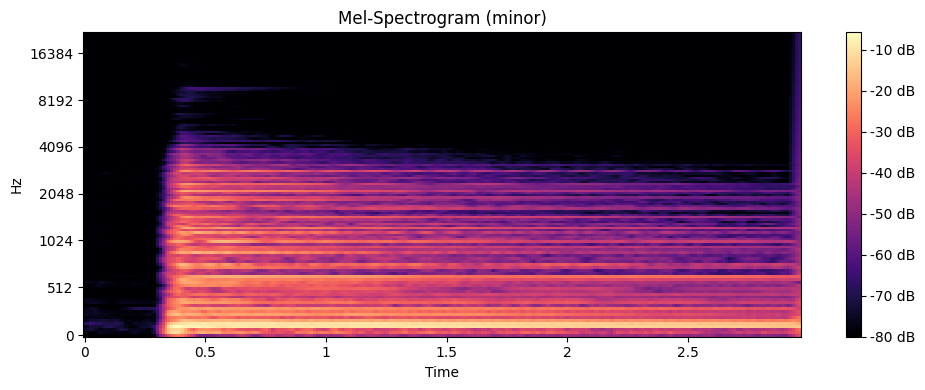

File Path: shords_dataset/minor/7_41.wav


In [160]:
print_random_mel_spectrograms(df_resized, num_samples=5)


In [161]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df_resized, test_size=0.2, random_state=42)

# Define dataset class
class MelSpectrogramDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        mel_spec = self.df['mel_spectrogram'].iloc[idx]
        class_label = self.df['class'].iloc[idx]
        class_label = 1 if class_label == "major" else 0
        # Convert mel-spectrogram to PyTorch tensor and add channel dimension
        mel_spec = torch.tensor(mel_spec).unsqueeze(0).float()
        
        # Convert class label to torch.LongTensor
        class_label = torch.tensor(class_label, dtype=torch.float)
        
        return mel_spec, class_label

# Create training dataset
train_dataset = MelSpectrogramDataset(train_df)

# Create validation dataset
val_dataset = MelSpectrogramDataset(val_df)

# Create DataLoader for training set
batch_size = 32  # Adjust batch size as needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation set
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [162]:
import torch.nn as nn
import torch.optim as optim

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 32 * 16, 512)  # Adjusted size based on CNN architecture
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)  # Adjust num_classes as per your dataset

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 32 * 16)        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1)  # Flatten the output to match the shape [batch_size]
        return x

# Example usage of CNN
model = CNN()
print(model)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Training and validation loop
num_epochs = 25
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for val_batch_idx, (val_inputs, val_labels) in enumerate(val_dataloader):
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item() * val_inputs.size(0)
            
            # Apply sigmoid to the outputs
            val_outputs = torch.sigmoid(val_outputs)
            # Threshold at 0.5
            predicted = (val_outputs > 0.5).float()
            correct_predictions += (predicted == val_labels).sum().item()
            total_predictions += val_labels.size(0)

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_accuracy = correct_predictions / total_predictions

    print(f'Epoch [{epoch+1}/{num_epochs}], '
        f'Train Loss: {epoch_loss:.4f}, '
        f'Val Loss: {val_epoch_loss:.4f}, '
        f'Val Accuracy: {val_accuracy:.4f}')

print('Finished Training')

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
Epoch [1/25], Train Loss: 384.4659, Val Loss: 0.6945, Val Accuracy: 0.4950
Epoch [2/25], Train Loss: 0.7098, Val Loss: 0.6853, Val Accuracy: 0.5248
Epoch [3/25], Train Loss: 0.6973, Val Loss: 0.6930, Val Accuracy: 0.5248
Epoch [4/25], Train Loss: 0.6941, Val Loss: 0.6953, Val Accuracy: 0.4752


KeyboardInterrupt: 